# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False

# Import Packages

In [2]:
import sys
sys.path.append('..')
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'
    
models_path = utils.get_m5_root_dir() + '/models/'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 4176.43 Mb (64.0% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(46097933, 33)
(46097933, 33)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_objective_function(y_pred, y_true):
    """
    Compute gradient and hessian of custom loss 
    
    :param y_pred: array containing the predicted values
    :param y_true: array containing the target values
    :return: gradient (1st derivative) and hessian (2nd derivative)
    """
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.125)
    hess = np.where(residual < 0, 2, 2 * 1.125)
    return grad, hess


def custom_evaluation_function(y_pred, y_true):
    """
    Compute the custom evaluation metric (asymetric RMSE) 
    
    :param y_pred: array containing the predicted values
    :param y_true: array containing the targed values
    :return: (eval_name, eval_result, is_higher_better)
    """
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.125)
    return "custom_asymmetric_rmse", np.sqrt(np.mean(loss)), False

In [7]:

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [8]:


model_params = {
    'seed': 10,
    'learning_rate': 0.25,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
    'num_leaves': 2^9,
}

In [9]:

for cat in df_merged.cat_id.drop_duplicates():
    
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    evals_result = {}
    start = time.time()
    
    print('log: create data sets')
    x_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    x_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    print('log: create LightGBM data sets')
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )

    print('log: model training')
    gbm= lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                    fobj=custom_objective_function,
                    feval = custom_evaluation_function
                   )
    
    
    print('log: save model and evals result')
    gbm.save_model(f'{models_path}gbm_cat_id_{cat}_{prefix}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(f'{models_path}evals_result_cat_id_{cat}_{prefix}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    print('\n Training for cat_id %s took %0.2f minutes.' %(cat, (time.time()-start)/60))




 ***** Computation for cat_id  1 *****
log: create data sets
log: create LightGBM data sets
log: model training


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's custom_asymmetric_rmse: 1.9103	valid_1's custom_asymmetric_rmse: 1.7351
Early stopping, best iteration is:
[26]	training's custom_asymmetric_rmse: 1.90985	valid_1's custom_asymmetric_rmse: 1.73506
log: save model and evals result

 Training for cat_id 1 took 2.38 minutes.

 ***** Computation for cat_id  2 *****
log: create data sets
log: create LightGBM data sets
log: model training
Training until validation scores don't improve for 20 rounds
[25]	training's custom_asymmetric_rmse: 1.64565	valid_1's custom_asymmetric_rmse: 1.54159
[50]	training's custom_asymmetric_rmse: 1.62523	valid_1's custom_asymmetric_rmse: 1.53558
[75]	training's custom_asymmetric_rmse: 1.61389	valid_1's custom_asymmetric_rmse: 1.53378
[100]	training's custom_asymmetric_rmse: 1.60377	valid_1's custom_asymmetric_rmse: 1.53093
[125]	training's custom_asymmetric_rmse: 1.59651	valid_1's custom_asymmetric_rmse: 1.52886
Early stopping, best ite

In [10]:

# keep date here, drop later
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]
x_pred['y_pred'] = np.nan


for cat in x_pred.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    x_pred.loc[x_pred.cat_id == cat,'y_pred'] = mod.predict(x_pred.loc[x_pred.cat_id == cat][features])

    

# Training Analysis


 ***** Computation for cat_id  1 *****


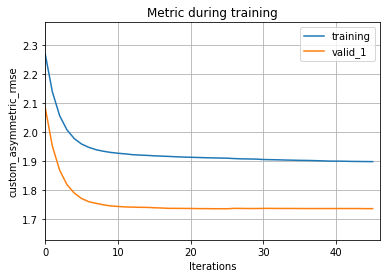

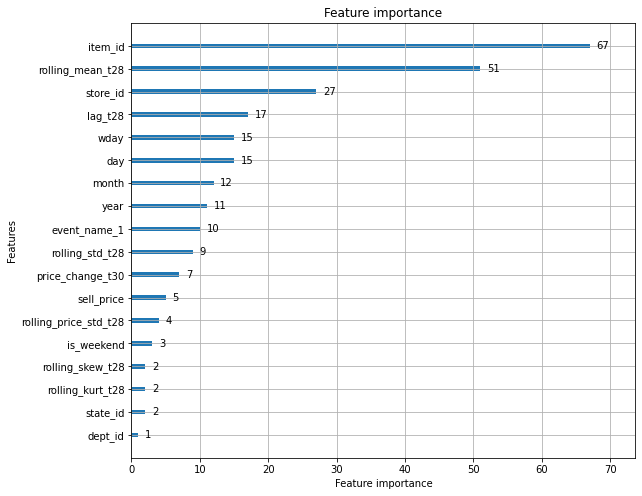


 ***** Computation for cat_id  2 *****


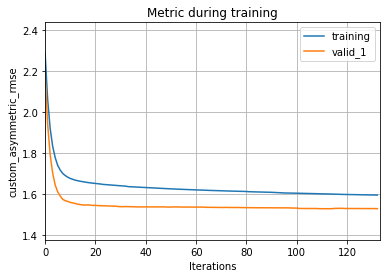

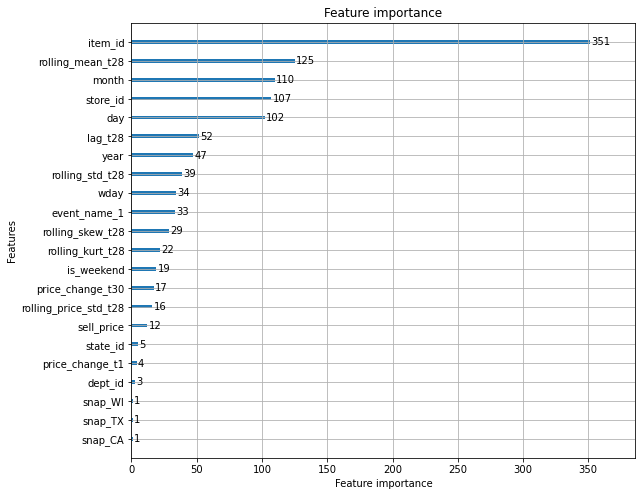


 ***** Computation for cat_id  0 *****


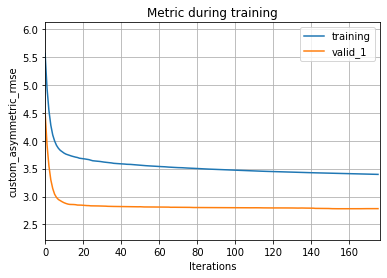

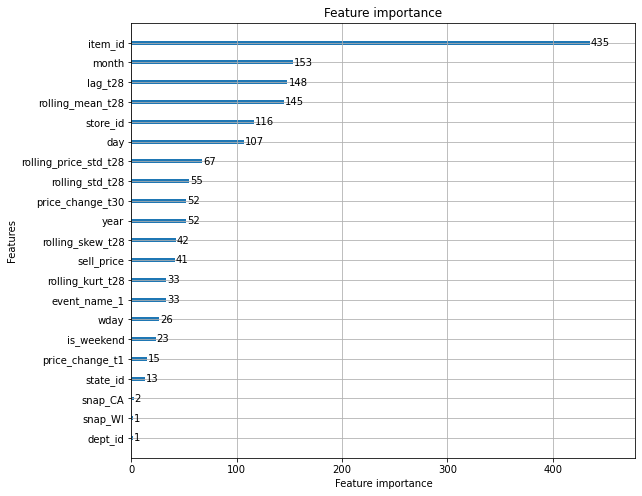

In [11]:

for cat in x_pred.cat_id.drop_duplicates():
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    evals = pickle.load(open(f'{models_path}evals_result_cat_id_{cat}_{prefix}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.savefig(f'learning_curves_cat_id_{cat}.png')
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig(f'feature_importance_cat_id_{cat}.png')
    plt.show()



    

# Compute RMSSE and WRMSSE on Validation Data

In [12]:
# compute forecasts, error and map it to df_merged to get ids

# create validation set containing all categories
df_last_28d = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'][features].copy()
df_last_28d['y_true'] = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27']['sale'].copy()

for cat in df_last_28d.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    df_last_28d.loc[df_last_28d.cat_id == cat,'y_pred'] = mod.predict(df_last_28d.loc[df_last_28d.cat_id == cat][features])
    
df_last_28d['error'] = (df_last_28d.y_true - df_last_28d.y_pred)
df_last_28d = df_last_28d.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_last_28d.head(10)

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_true,y_pred,error,id
0,1437,3,1,0,0,2016,3,28,0,3,...,1.423363,1.000000,1.231763,0.0,0.0,8.622286e-08,1.0,0.929098,0.070902,HOBBIES_1_001_CA_1_validation
1,1437,3,1,0,0,2016,3,29,0,4,...,1.310783,1.033333,1.245221,0.0,0.0,8.622286e-08,0.0,0.976885,-0.976885,HOBBIES_1_001_CA_1_validation
2,1437,3,1,0,0,2016,3,30,0,5,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.929098,-0.929098,HOBBIES_1_001_CA_1_validation
3,1437,3,1,0,0,2016,3,31,0,6,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.934045,-0.934045,HOBBIES_1_001_CA_1_validation
4,1437,3,1,0,0,2016,4,1,0,7,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,1.030566,-1.030566,HOBBIES_1_001_CA_1_validation
5,1437,3,1,0,0,2016,4,2,1,1,...,1.356940,0.966667,1.272612,0.0,0.0,8.622286e-08,0.0,1.113484,-1.113484,HOBBIES_1_001_CA_1_validation
6,1437,3,1,0,0,2016,4,3,1,2,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,1.0,1.136828,-0.136828,HOBBIES_1_001_CA_1_validation
7,1437,3,1,0,0,2016,4,4,0,3,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,0.0,0.929098,-0.929098,HOBBIES_1_001_CA_1_validation
8,1437,3,1,0,0,2016,4,5,0,4,...,1.331552,1.000000,1.259447,0.0,0.0,8.622286e-08,4.0,0.929098,3.070902,HOBBIES_1_001_CA_1_validation
9,1437,3,1,0,0,2016,4,6,0,5,...,1.444642,0.966667,1.245221,0.0,0.0,8.622286e-08,2.0,0.934045,1.065955,HOBBIES_1_001_CA_1_validation


In [13]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_last_28d.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [14]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [15]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))
# WRMSSE = 0.01167

WRMSSE = 0.88781


In [16]:
# show RMSSE and corresponding weights
rmsse_df.sort_values(by='RMSSE', ascending=False).head(20)

,RMSSE,id,weights,w_times_RMSSE
20322,5.128928,HOUSEHOLD_1_032_CA_3_validation,0.000218,0.001119
21772,4.824282,HOUSEHOLD_1_180_CA_3_validation,0.000038,0.000185
13668,4.812349,FOODS_3_757_WI_2_validation,0.000293,0.001411
9942,4.422923,FOODS_3_382_CA_3_validation,0.000009,0.000040
12726,4.194413,FOODS_3_660_TX_3_validation,0.000124,0.000519
26759,4.039766,HOUSEHOLD_2_142_WI_3_validation,0.000121,0.000488
26956,3.914527,HOUSEHOLD_2_162_TX_3_validation,0.000019,0.000075
12305,3.787468,FOODS_3_618_TX_2_validation,0.000084,0.000318
20324,3.786250,HOUSEHOLD_1_032_TX_1_validation,0.000134,0.000508
7596,3.703879,FOODS_3_147_TX_3_validation,0.000157,0.000583


In [17]:
# analyse time series (manually)
rel_id = 'HOBBIES_2_107_TX_2_validation'
df_last_28d.loc[df_last_28d.id == rel_id][[
    'id',
    'month',
    'day',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'is_weekend',
    'wday',
    'sell_price',
    'y_pred',
    'y_true',
    'error',
]]

,id,month,day,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
441476,HOBBIES_2_107_TX_2_validation,3,28,13,1,3,1,0,3,0.5,0.323969,1.0,0.676031
441477,HOBBIES_2_107_TX_2_validation,3,29,13,1,3,1,0,4,0.5,0.323969,0.0,-0.323969
441478,HOBBIES_2_107_TX_2_validation,3,30,13,1,3,1,0,5,0.5,0.328916,14.0,13.671084
441479,HOBBIES_2_107_TX_2_validation,3,31,13,1,3,1,0,6,0.5,0.323969,0.0,-0.323969
441480,HOBBIES_2_107_TX_2_validation,4,1,13,1,3,1,0,7,0.5,0.354124,0.0,-0.354124
441481,HOBBIES_2_107_TX_2_validation,4,2,13,1,3,1,1,1,0.5,0.405074,1.0,0.594926
441482,HOBBIES_2_107_TX_2_validation,4,3,13,1,3,1,1,2,0.5,0.428418,1.0,0.571582
441483,HOBBIES_2_107_TX_2_validation,4,4,13,1,3,1,0,3,0.5,0.282784,1.0,0.717216
441484,HOBBIES_2_107_TX_2_validation,4,5,13,1,3,1,0,4,0.5,0.282784,1.0,0.717216
441485,HOBBIES_2_107_TX_2_validation,4,6,13,1,3,1,0,5,0.5,0.231957,0.0,-0.231957


# Error for different Predicting Intervals

In [18]:
x_val_pred = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features].copy()
y_val_pred = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']


x_val_pred['y_pred'] = np.nan


for cat in x_val_pred.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    x_val_pred.loc[x_val_pred.cat_id == cat,'y_pred'] = mod.predict(x_val_pred.loc[x_val_pred.cat_id == cat][features])


In [19]:
x_val_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
44390493,1437,3,1,0,0,2016,3,28,0,3,...,8.26,0.0,1.165137,1.423363,1.000000,1.231763e+00,0.0,0.0,8.622286e-08,0.929098
44390494,1438,3,1,0,0,2016,3,28,0,3,...,3.97,0.0,2.859231,1.884415,0.166667,3.790490e-01,0.0,0.0,0.000000e+00,0.201778
44390495,1439,3,1,0,0,2016,3,28,0,3,...,2.97,0.0,-1.455547,0.919500,0.300000,4.660916e-01,0.0,0.0,0.000000e+00,0.290600
44390496,1440,3,1,0,0,2016,3,28,0,3,...,4.64,0.0,-0.455635,0.679141,2.200000,1.954659e+00,0.0,0.0,0.000000e+00,1.917111
44390497,1441,3,1,0,0,2016,3,28,0,3,...,2.88,1.0,1.330443,1.329091,1.133333,1.306043e+00,0.0,0.0,4.434852e-08,0.969622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45244208,1432,2,0,9,2,2016,4,24,1,2,...,2.98,0.0,4.439427,2.147972,0.266667,5.832923e-01,0.0,0.0,7.810822e-08,0.446141
45244209,1433,2,0,9,2,2016,4,24,1,2,...,2.48,0.0,NaN,NaN,0.000000,4.427322e-08,0.0,0.0,1.872101e-01,0.795885
45244210,1434,2,0,9,2,2016,4,24,1,2,...,3.98,1.0,-0.928225,0.038939,1.233333,9.352607e-01,0.0,0.0,0.000000e+00,1.154295
45244211,1435,2,0,9,2,2016,4,24,1,2,...,1.28,4.0,0.021799,0.686957,1.166667,1.085431e+00,0.0,0.0,0.000000e+00,1.682527


In [20]:
id_mapping_table = df_merged[['id', 'date','item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
id_mapping_table

,id,date,item_id,year,month,day,store_id
0,HOBBIES_1_004_CA_1_validation,2011-03-31,1440,2011,3,31,0
1,HOBBIES_1_008_CA_1_validation,2011-03-31,1444,2011,3,31,0
2,HOBBIES_1_009_CA_1_validation,2011-03-31,1445,2011,3,31,0
3,HOBBIES_1_010_CA_1_validation,2011-03-31,1446,2011,3,31,0
4,HOBBIES_1_012_CA_1_validation,2011-03-31,1448,2011,3,31,0
...,...,...,...,...,...,...,...
46097928,FOODS_3_823_WI_3_validation,2016-05-22,1432,2016,5,22,9
46097929,FOODS_3_824_WI_3_validation,2016-05-22,1433,2016,5,22,9
46097930,FOODS_3_825_WI_3_validation,2016-05-22,1434,2016,5,22,9
46097931,FOODS_3_826_WI_3_validation,2016-05-22,1435,2016,5,22,9


In [21]:
df_tmp = x_val_pred.copy()
df_tmp = df_tmp.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'])
df_tmp['y_true'] = y_val_pred.values
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred,id,date,y_true,error
0,1437,3,1,0,0,2016,3,28,0,3,...,1.000000,1.231763e+00,0.0,0.0,8.622286e-08,0.929098,HOBBIES_1_001_CA_1_validation,2016-03-28,1.0,0.070902
1,1438,3,1,0,0,2016,3,28,0,3,...,0.166667,3.790490e-01,0.0,0.0,0.000000e+00,0.201778,HOBBIES_1_002_CA_1_validation,2016-03-28,1.0,0.798222
2,1439,3,1,0,0,2016,3,28,0,3,...,0.300000,4.660916e-01,0.0,0.0,0.000000e+00,0.290600,HOBBIES_1_003_CA_1_validation,2016-03-28,0.0,-0.290600
3,1440,3,1,0,0,2016,3,28,0,3,...,2.200000,1.954659e+00,0.0,0.0,0.000000e+00,1.917111,HOBBIES_1_004_CA_1_validation,2016-03-28,0.0,-1.917111
4,1441,3,1,0,0,2016,3,28,0,3,...,1.133333,1.306043e+00,0.0,0.0,4.434852e-08,0.969622,HOBBIES_1_005_CA_1_validation,2016-03-28,1.0,0.030378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,1432,2,0,9,2,2016,4,24,1,2,...,0.266667,5.832923e-01,0.0,0.0,7.810822e-08,0.446141,FOODS_3_823_WI_3_validation,2016-04-24,1.0,0.553859
853716,1433,2,0,9,2,2016,4,24,1,2,...,0.000000,4.427322e-08,0.0,0.0,1.872101e-01,0.795885,FOODS_3_824_WI_3_validation,2016-04-24,0.0,-0.795885
853717,1434,2,0,9,2,2016,4,24,1,2,...,1.233333,9.352607e-01,0.0,0.0,0.000000e+00,1.154295,FOODS_3_825_WI_3_validation,2016-04-24,0.0,-1.154295
853718,1435,2,0,9,2,2016,4,24,1,2,...,1.166667,1.085431e+00,0.0,0.0,0.000000e+00,1.682527,FOODS_3_826_WI_3_validation,2016-04-24,3.0,1.317473


In [22]:
tmp = df_tmp[['id', 'year', 'month', 'day', 'y_pred', 'y_true', 'error']]
tmp_grouped = tmp.groupby(['year', 'month', 'day'])


for date, row in tmp_grouped:
    
    # compute RMSSE and store it in dict
    rmsse_dict = {}

    for name, group in row.groupby(['id']):

        scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
        weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]

        rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
        
        
    # convert dict to dataframe
    rmsse_df = pd.DataFrame(rmsse_dict).T
    rmsse_df['id'] = rmsse_df.index
    rmsse_df = rmsse_df.reset_index(drop=True)
    rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

    # add weights to df and compute weights multiplied by RMSSE
    rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
    rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

    # sort values by their impact
    rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)

    print('WRMSSE of %s = %0.5f' % (date, np.sum(rmsse_df.RMSSE * rmsse_df.weights)))
    # WRMSSE overall = 0.01167

    
    


WRMSSE of (2016, 3, 28) = 0.62162
WRMSSE of (2016, 3, 29) = 0.59490
WRMSSE of (2016, 3, 30) = 0.59194
WRMSSE of (2016, 3, 31) = 0.61326
WRMSSE of (2016, 4, 1) = 0.71791
WRMSSE of (2016, 4, 2) = 0.78229
WRMSSE of (2016, 4, 3) = 0.86175
WRMSSE of (2016, 4, 4) = 0.69227
WRMSSE of (2016, 4, 5) = 0.68544
WRMSSE of (2016, 4, 6) = 0.67650
WRMSSE of (2016, 4, 7) = 0.65071
WRMSSE of (2016, 4, 8) = 0.70617
WRMSSE of (2016, 4, 9) = 0.82896
WRMSSE of (2016, 4, 10) = 0.84107
WRMSSE of (2016, 4, 11) = 0.72585
WRMSSE of (2016, 4, 12) = 0.67717
WRMSSE of (2016, 4, 13) = 0.62369
WRMSSE of (2016, 4, 14) = 0.65613
WRMSSE of (2016, 4, 15) = 0.70649
WRMSSE of (2016, 4, 16) = 0.75197
WRMSSE of (2016, 4, 17) = 0.79349
WRMSSE of (2016, 4, 18) = 0.66828
WRMSSE of (2016, 4, 19) = 0.63863
WRMSSE of (2016, 4, 20) = 0.61368
WRMSSE of (2016, 4, 21) = 0.62165
WRMSSE of (2016, 4, 22) = 0.65438
WRMSSE of (2016, 4, 23) = 0.74337
WRMSSE of (2016, 4, 24) = 0.79103


# Printout Forecasts

In [23]:
x_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
45244213,1437,3,1,0,0,2016,4,25,0,3,...,8.38,1.0,0.246603,0.763245,1.033333,0.927858,0.0,0.0,5.968164e-02,0.889323
45244214,1438,3,1,0,0,2016,4,25,0,3,...,3.97,1.0,-1.731692,0.744880,0.333333,0.479463,0.0,0.0,0.000000e+00,0.336733
45244215,1439,3,1,0,0,2016,4,25,0,3,...,2.97,0.0,16.585960,3.904594,0.500000,1.167077,0.0,0.0,0.000000e+00,0.429132
45244216,1440,3,1,0,0,2016,4,25,0,3,...,4.64,0.0,-0.529831,0.790924,1.966667,2.075860,0.0,0.0,0.000000e+00,1.715232
45244217,1441,3,1,0,0,2016,4,25,0,3,...,2.88,1.0,-0.717982,0.542001,1.100000,0.959526,0.0,0.0,4.434852e-08,0.924901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097928,1432,2,0,9,2,2016,5,22,1,2,...,2.98,1.0,6.029183,2.758372,0.200000,0.550861,0.0,0.0,7.810822e-08,0.482933
46097929,1433,2,0,9,2,2016,5,22,1,2,...,2.48,0.0,1.580669,1.621490,0.300000,0.534983,0.0,0.0,4.964984e-08,0.326504
46097930,1434,2,0,9,2,2016,5,22,1,2,...,3.98,0.0,1.720479,1.485839,0.866667,1.136642,0.0,0.0,0.000000e+00,0.753910
46097931,1435,2,0,9,2,2016,5,22,1,2,...,1.28,3.0,-0.140881,0.963120,1.066667,1.172481,0.0,0.0,0.000000e+00,1.331296


In [24]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [25]:
id_mapping_table

,id,item_id,year,month,day,store_id
0,HOBBIES_1_004_CA_1_validation,1440,2011,3,31,0
1,HOBBIES_1_008_CA_1_validation,1444,2011,3,31,0
2,HOBBIES_1_009_CA_1_validation,1445,2011,3,31,0
3,HOBBIES_1_010_CA_1_validation,1446,2011,3,31,0
4,HOBBIES_1_012_CA_1_validation,1448,2011,3,31,0
...,...,...,...,...,...,...
46097928,FOODS_3_823_WI_3_validation,1432,2016,5,22,9
46097929,FOODS_3_824_WI_3_validation,1433,2016,5,22,9
46097930,FOODS_3_825_WI_3_validation,1434,2016,5,22,9
46097931,FOODS_3_826_WI_3_validation,1435,2016,5,22,9


In [26]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [27]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.767845,0.666948,0.666948,0.642086,1.178350,0.974630,1.057702,1.359227,1.045541,...,1.120147,1.498642,1.288710,1.618064,1.227882,1.227882,1.154931,1.093950,1.353069,1.187661
1,FOODS_1_001_CA_2_validation,0.969817,0.915115,0.915115,0.708292,0.762994,0.852947,0.936019,0.707736,0.662860,...,0.582656,0.630578,3.285594,0.839846,0.808058,0.808058,1.235602,0.996633,1.115205,1.551954
2,FOODS_1_001_CA_3_validation,1.261748,1.066500,1.091362,1.066500,1.121202,1.236017,1.294227,1.387205,1.342329,...,1.347040,1.465613,4.347987,1.540539,1.189818,1.189818,1.187519,1.242221,1.808734,1.783871
3,FOODS_1_001_CA_4_validation,0.526099,0.400340,0.400340,0.400340,0.455042,0.544994,0.628067,0.660781,0.545254,...,0.336336,0.454909,0.504900,0.499050,0.279765,0.279765,0.277466,0.357030,0.475603,0.475603
4,FOODS_1_001_TX_1_validation,0.455042,0.400340,0.400340,0.400340,0.455042,0.544994,0.647000,0.590130,0.549923,...,0.400276,0.518849,0.568839,0.382205,0.215826,0.215826,0.213526,0.268228,0.386801,0.386801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.251576,0.232944,0.247480,0.247480,0.280613,0.363495,0.401339,0.307980,0.303884,...,0.299000,0.514435,0.381747,0.234797,0.211286,0.225822,0.206737,0.258955,0.332409,0.323277
30486,HOUSEHOLD_2_516_TX_3_validation,0.151473,0.157131,0.157131,0.142594,0.190264,0.238580,0.237607,0.153175,0.197650,...,0.369435,0.196177,0.252714,0.184167,0.170408,0.170408,0.165860,0.218078,0.256967,0.247835
30487,HOUSEHOLD_2_516_WI_1_validation,0.093476,0.076368,0.076368,0.076368,0.102948,0.151265,0.158912,0.111454,0.102575,...,0.133170,0.149294,0.145041,0.097583,0.083825,0.083825,0.079276,0.110405,0.149294,0.140162
30488,HOUSEHOLD_2_516_WI_2_validation,0.087991,0.079112,0.079112,0.079112,0.105692,0.154009,0.161656,0.114198,0.105319,...,0.100934,0.139823,0.135570,0.088112,0.074354,0.074354,0.096557,0.113149,0.152038,0.142906


# Increase Predictions for Food Items as they are underestimated

In [28]:

df = df_last_28d.copy()
df['error'] = (df.y_true - df.y_pred)

# compute RMSSE and store it in dict
rmsse_dict = {}



print('computing RMSSE')
for name, group in df.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]

    
print('converting dict to dataframe')
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

print('add weights to df and compute weights multiplied by RMSSE')
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

print('sort values by their impact')
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)



print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))


computing RMSSE
converting dict to dataframe
add weights to df and compute weights multiplied by RMSSE
sort values by their impact
WRMSSE = 0.88781


In [29]:
rmsse_df.head(50)

,RMSSE,id,weights,w_times_RMSSE
20322,5.128928,HOUSEHOLD_1_032_CA_3_validation,0.000218,0.001119
21772,4.824282,HOUSEHOLD_1_180_CA_3_validation,0.000038,0.000185
13668,4.812349,FOODS_3_757_WI_2_validation,0.000293,0.001411
9942,4.422923,FOODS_3_382_CA_3_validation,0.000009,0.000040
12726,4.194413,FOODS_3_660_TX_3_validation,0.000124,0.000519
26759,4.039766,HOUSEHOLD_2_142_WI_3_validation,0.000121,0.000488
26956,3.914527,HOUSEHOLD_2_162_TX_3_validation,0.000019,0.000075
12305,3.787468,FOODS_3_618_TX_2_validation,0.000084,0.000318
20324,3.786250,HOUSEHOLD_1_032_TX_1_validation,0.000134,0.000508
7596,3.703879,FOODS_3_147_TX_3_validation,0.000157,0.000583


In [30]:
# compute pertentage error of forecasts and corresponding ids
factors = []
for i in rmsse_df.id:
    factors.append(df_last_28d.loc[df_last_28d.id == i].y_pred.mean() / df_last_28d.loc[df_last_28d.id == i].y_true.mean())

labels_0 = rmsse_df.id[:50].values
labels_1 = rmsse_df.id[50:100].values
labels_2 = rmsse_df.id[100:200].values
labels_3 = rmsse_df.id[200:300].values


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [31]:
# get list of food elements
food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)

In [32]:
# print fraction of predicted values compared to target
# print fraction of predicted values compared to target
print(np.mean(factors[0:50]))
print(np.mean(factors[50:100]))
print(np.mean(factors[100:200]))
print(np.mean(factors[200:300]))
print(np.mean(factors[300:400]))
print(np.mean(factors[400:500]))
print(np.mean(factors[500:]))

1.0491439642641185
inf
inf
0.7676102251919061
1.2187600036795685
inf
inf


In [33]:
submission_df.loc[submission_df.id.isin(labels_0),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_0),
                                            f_list] * 1.3

submission_df.loc[submission_df.id.isin(labels_1),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_1),
                                            f_list] * 1.25

submission_df.loc[submission_df.id.isin(labels_2),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_2),
                                            f_list] * 1.08

submission_df.loc[submission_df.id.isin(labels_3),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_3),
                                            f_list] * 0.96


submission_df



,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.767845,0.666948,0.666948,0.642086,1.178350,0.974630,1.057702,1.359227,1.045541,...,1.120147,1.498642,1.288710,1.618064,1.227882,1.227882,1.154931,1.093950,1.353069,1.187661
1,FOODS_1_001_CA_2_validation,0.969817,0.915115,0.915115,0.708292,0.762994,0.852947,0.936019,0.707736,0.662860,...,0.582656,0.630578,3.285594,0.839846,0.808058,0.808058,1.235602,0.996633,1.115205,1.551954
2,FOODS_1_001_CA_3_validation,1.261748,1.066500,1.091362,1.066500,1.121202,1.236017,1.294227,1.387205,1.342329,...,1.347040,1.465613,4.347987,1.540539,1.189818,1.189818,1.187519,1.242221,1.808734,1.783871
3,FOODS_1_001_CA_4_validation,0.526099,0.400340,0.400340,0.400340,0.455042,0.544994,0.628067,0.660781,0.545254,...,0.336336,0.454909,0.504900,0.499050,0.279765,0.279765,0.277466,0.357030,0.475603,0.475603
4,FOODS_1_001_TX_1_validation,0.455042,0.400340,0.400340,0.400340,0.455042,0.544994,0.647000,0.590130,0.549923,...,0.400276,0.518849,0.568839,0.382205,0.215826,0.215826,0.213526,0.268228,0.386801,0.386801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.251576,0.232944,0.247480,0.247480,0.280613,0.363495,0.401339,0.307980,0.303884,...,0.299000,0.514435,0.381747,0.234797,0.211286,0.225822,0.206737,0.258955,0.332409,0.323277
30486,HOUSEHOLD_2_516_TX_3_validation,0.151473,0.157131,0.157131,0.142594,0.190264,0.238580,0.237607,0.153175,0.197650,...,0.369435,0.196177,0.252714,0.184167,0.170408,0.170408,0.165860,0.218078,0.256967,0.247835
30487,HOUSEHOLD_2_516_WI_1_validation,0.093476,0.076368,0.076368,0.076368,0.102948,0.151265,0.158912,0.111454,0.102575,...,0.133170,0.149294,0.145041,0.097583,0.083825,0.083825,0.079276,0.110405,0.149294,0.140162
30488,HOUSEHOLD_2_516_WI_2_validation,0.087991,0.079112,0.079112,0.079112,0.105692,0.154009,0.161656,0.114198,0.105319,...,0.100934,0.139823,0.135570,0.088112,0.074354,0.074354,0.096557,0.113149,0.152038,0.142906


In [34]:
# Submit to Kaggle 

In [35]:
submission_df.loc[submission_df.id.isin(labels_0),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_0),
                                            f_list] * 1.3

submission_df.loc[submission_df.id.isin(labels_1),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_1),
                                            f_list] * 1.25

submission_df.loc[submission_df.id.isin(labels_2),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_2),
                                            f_list] * 1.08

submission_df.loc[submission_df.id.isin(labels_3),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_3),
                                            f_list] * 0.96


submission_df



,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.767845,0.666948,0.666948,0.642086,1.178350,0.974630,1.057702,1.359227,1.045541,...,1.120147,1.498642,1.288710,1.618064,1.227882,1.227882,1.154931,1.093950,1.353069,1.187661
1,FOODS_1_001_CA_2_validation,0.969817,0.915115,0.915115,0.708292,0.762994,0.852947,0.936019,0.707736,0.662860,...,0.582656,0.630578,3.285594,0.839846,0.808058,0.808058,1.235602,0.996633,1.115205,1.551954
2,FOODS_1_001_CA_3_validation,1.261748,1.066500,1.091362,1.066500,1.121202,1.236017,1.294227,1.387205,1.342329,...,1.347040,1.465613,4.347987,1.540539,1.189818,1.189818,1.187519,1.242221,1.808734,1.783871
3,FOODS_1_001_CA_4_validation,0.526099,0.400340,0.400340,0.400340,0.455042,0.544994,0.628067,0.660781,0.545254,...,0.336336,0.454909,0.504900,0.499050,0.279765,0.279765,0.277466,0.357030,0.475603,0.475603
4,FOODS_1_001_TX_1_validation,0.455042,0.400340,0.400340,0.400340,0.455042,0.544994,0.647000,0.590130,0.549923,...,0.400276,0.518849,0.568839,0.382205,0.215826,0.215826,0.213526,0.268228,0.386801,0.386801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.251576,0.232944,0.247480,0.247480,0.280613,0.363495,0.401339,0.307980,0.303884,...,0.299000,0.514435,0.381747,0.234797,0.211286,0.225822,0.206737,0.258955,0.332409,0.323277
30486,HOUSEHOLD_2_516_TX_3_validation,0.151473,0.157131,0.157131,0.142594,0.190264,0.238580,0.237607,0.153175,0.197650,...,0.369435,0.196177,0.252714,0.184167,0.170408,0.170408,0.165860,0.218078,0.256967,0.247835
30487,HOUSEHOLD_2_516_WI_1_validation,0.093476,0.076368,0.076368,0.076368,0.102948,0.151265,0.158912,0.111454,0.102575,...,0.133170,0.149294,0.145041,0.097583,0.083825,0.083825,0.079276,0.110405,0.149294,0.140162
30488,HOUSEHOLD_2_516_WI_2_validation,0.087991,0.079112,0.079112,0.079112,0.105692,0.154009,0.161656,0.114198,0.105319,...,0.100934,0.139823,0.135570,0.088112,0.074354,0.074354,0.096557,0.113149,0.152038,0.142906


# Submit to Kaggle 

In [36]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation',
                          value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)